## Steps:
- ### Data transformation
1. For each movement, turn emg data into a (n_repetitions * n_channels * n_time_steps) tensor. Reshape the tensor to get a ({n_repetitions * n_time_steps} * n_channels) matrix for each movement.
2. Do the same for the acc data.
3. Do the same for glove data.
- ### Data Visualization
1. Plot the data and look for strange values or behavior.
- ### Window Selection and Feature/Label Extraction
1. Choose a time window. Repeat the next steps for each movement:
2. For each time window, for each channel, compute a set of features for the emg matrix.
3. Look at the features and discard those that don't make sense.
4. Repeat 2. and 3. for the acc matrix.
5. For each time window, select a time point and set the ground truth of that window to be the values of the glove channels for that time point.
- ### Training, Validation, Test
1. ~~Pick a Regression model from sklearn.~~ Use XGBoost!
2. Pick a subset of data for training.
2. Train the model.
3. Use the remaining data and the same (or a different one?) subset of movements to do validation and hyperparameter tuning (Grid Search).
4. Test the model's accuracy on the test data.

In [286]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pywt
import pandas as pd
import scipy.stats as stats

from scipy.io import loadmat

from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_regression, f_regression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

In [287]:
# Select dataset
subject = 1
acquisition = 1

data1 = loadmat(f'data/S{1}_E1_A{1}.mat')
data2 = loadmat(f'data/S{1}_E1_A{2}.mat')
data3 = loadmat(f'data/S{1}_E1_A{3}.mat')

### Data Transformation

In [288]:
def stimulus_dict_maker(full_data, data_type):
    """
    Turns loaded .mat data into a tensor for each movement.
    
    ## Parameters:
        - full_data: dict
            
            Data as loaded from a .mat file.
        - data_type: str
            
            Dict key for the selected data type.

    ## Returns:
        - stimulus_dict: dict
            
            Contains a ({n_repetitions * n_time_steps} * n_channels) matrix for each movement.
        - concat_points: np.ndarray
            
            Contains points where repetitions are concatenated.
    """
    data = full_data[data_type]
    if data_type == 'emg':
        data = abs(data)
    stimulus = full_data["stimulus"]
    repetition = full_data["repetition"]

    n_channels = data.shape[1]
    print(f'Channels: {n_channels}')

    n_stimuli = int(np.unique(stimulus).size - 1)  # remove rest
    print(f'Stimuli: {n_stimuli}')
    n_repetitions = int(np.unique(repetition).size - 1)  # remove rest
    print(f'Repetitions: {n_repetitions}')

    dur = np.zeros((n_stimuli), int)
    for i in range(n_stimuli):
        sel = np.squeeze(stimulus == (i + 1))
        dur[i] = data[sel, :].shape[0]

    concat_points = np.zeros((n_repetitions, n_stimuli))

    stimulus_dict = {}
    for stimulus_index in range(n_stimuli):
        n_tsteps = dur[stimulus_index]
        n_rows = n_tsteps
        n_columns = n_channels

        tensor = np.zeros((n_rows, n_columns))
        cumulative_rep_tsteps = 0

        for rep_index in range(n_repetitions):
            sel = np.squeeze(np.logical_and(stimulus == (stimulus_index + 1), repetition == (rep_index + 1)))
            selected_data = data[sel, :]
            rep_tsteps = selected_data.shape[0]
            # print(selected_data[:,0])
            # print(cumulative_rep_tsteps)
            # print(tsteps)
            tensor[cumulative_rep_tsteps:cumulative_rep_tsteps + rep_tsteps, :] += selected_data
            # print(cumulative_rep_tsteps, cumulative_rep_tsteps + rep_tsteps)
            cumulative_rep_tsteps += rep_tsteps
            concat_points[rep_index, stimulus_index] = cumulative_rep_tsteps
            # print(tensor[:,0])
        
        # print(f'Movement {stimulus_index + 1} concatenation points: \n{concat_points[:, stimulus_index]}')

        stimulus_dict[f'{stimulus_index}'] = tensor
    return stimulus_dict, concat_points

In [289]:
print("Acquisition 1")

emg_dict1, emg_con1 = stimulus_dict_maker(data1, 'emg')
acc_dict1, acc_con1 = stimulus_dict_maker(data1, 'acc')
glove_dict1, glove_con1 = stimulus_dict_maker(data1, 'glove')
print()
print("Acquisition 2")
print()
emg_dict2, emg_con2 = stimulus_dict_maker(data2, 'emg')
acc_dict2, acc_con2 = stimulus_dict_maker(data2, 'acc')
glove_dict2, glove_con2 = stimulus_dict_maker(data2, 'glove')
print()
print("Acquisition 3")
print()
emg_dict3, emg_con3 = stimulus_dict_maker(data3, 'emg')
acc_dict3, acc_con3 = stimulus_dict_maker(data3, 'acc')
glove_dict3, glove_con3 = stimulus_dict_maker(data3, 'glove')

Acquisition 1
Channels: 16
Stimuli: 9
Repetitions: 10
Channels: 48
Stimuli: 9
Repetitions: 10
Channels: 18
Stimuli: 9
Repetitions: 10

Acquisition 2

Channels: 16
Stimuli: 9
Repetitions: 10
Channels: 48
Stimuli: 9
Repetitions: 10
Channels: 18
Stimuli: 9
Repetitions: 10

Acquisition 3

Channels: 16
Stimuli: 9
Repetitions: 2
Channels: 48
Stimuli: 9
Repetitions: 2
Channels: 18
Stimuli: 9
Repetitions: 2


### Data Visualization

In [290]:
def plot_data_difference(emg_dict, emg_con, acc_dict, acc_con, glove_dict, glove_con, title, fname):
    movement = 1

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
    ax = ax.ravel()

    ax[0].plot(emg_dict[str(movement)][1:, :] - emg_dict[str(movement)][:-1, :])
    for i in range(emg_con.shape[0]):
        ax[0].axvline(x=emg_con[i,movement], color='red', linestyle='--', linewidth=0.25)

    ax[1].plot(acc_dict[str(movement)][1:, :] - acc_dict[str(movement)][:-1, :])
    for i in range(acc_con.shape[0]):
        ax[1].axvline(x=acc_con[i,movement], color='red', linestyle='--', linewidth=0.25)

    ax[2].plot(glove_dict[str(movement)][1:, :] - glove_dict[str(movement)][:-1, :])
    for i in range(glove_con.shape[0]):
        ax[2].axvline(x=glove_con[i,movement], color='red', linestyle='--', linewidth=0.25)

    fig.suptitle(title, fontsize = 16)
    ax[0].set_title('EMG')
    ax[1].set_title('Accelerometer')
    ax[2].set_title('Glove')
    ax[0].set_xlabel('Time')
    ax[1].set_xlabel('Time')
    ax[2].set_xlabel('Time')
    ax[0].set_ylabel('Recorded signal')
    ax[1].set_ylabel('Recorded signal')
    ax[2].set_ylabel('Recorded signal')
    plt.savefig(fname)
    plt.show()

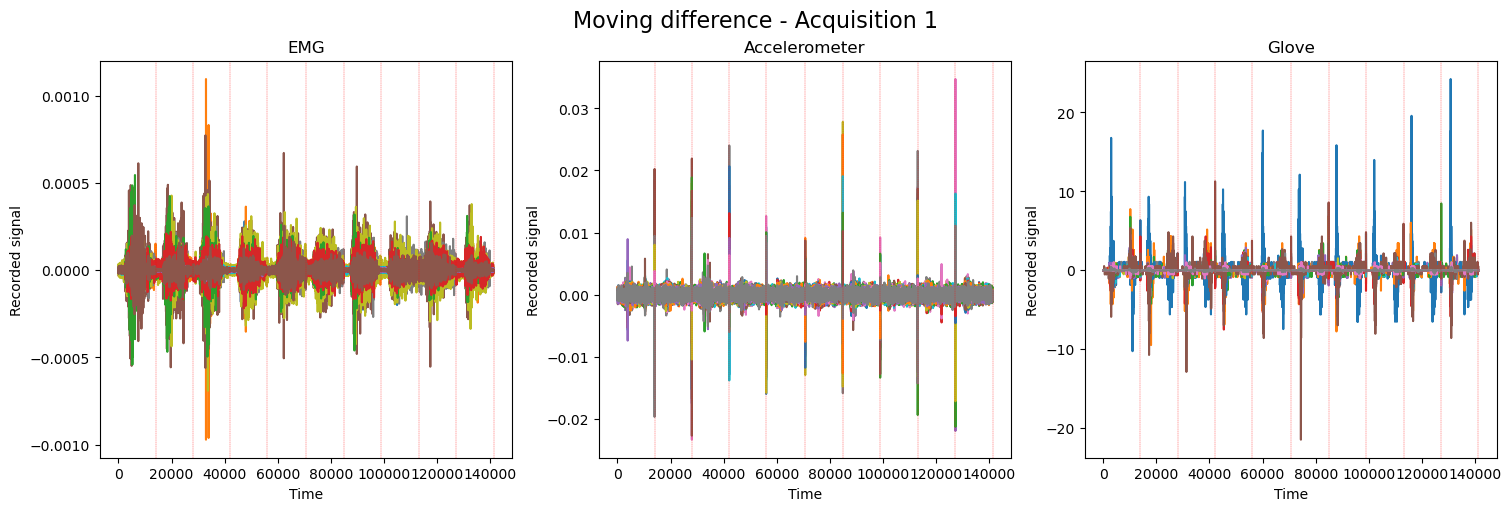

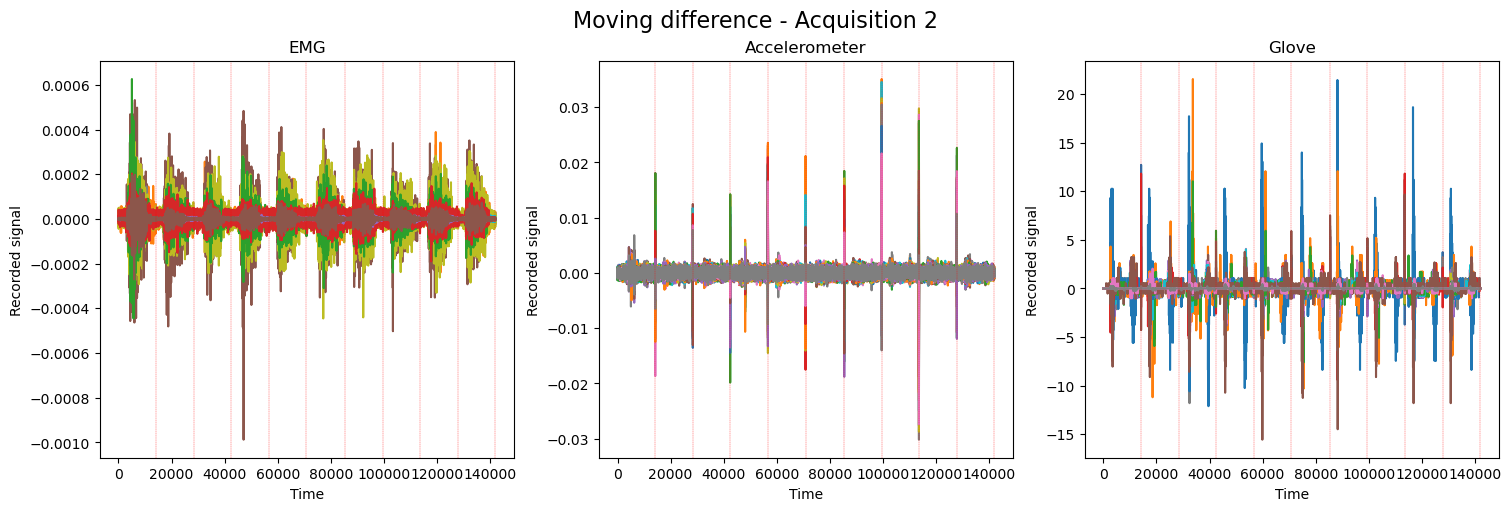

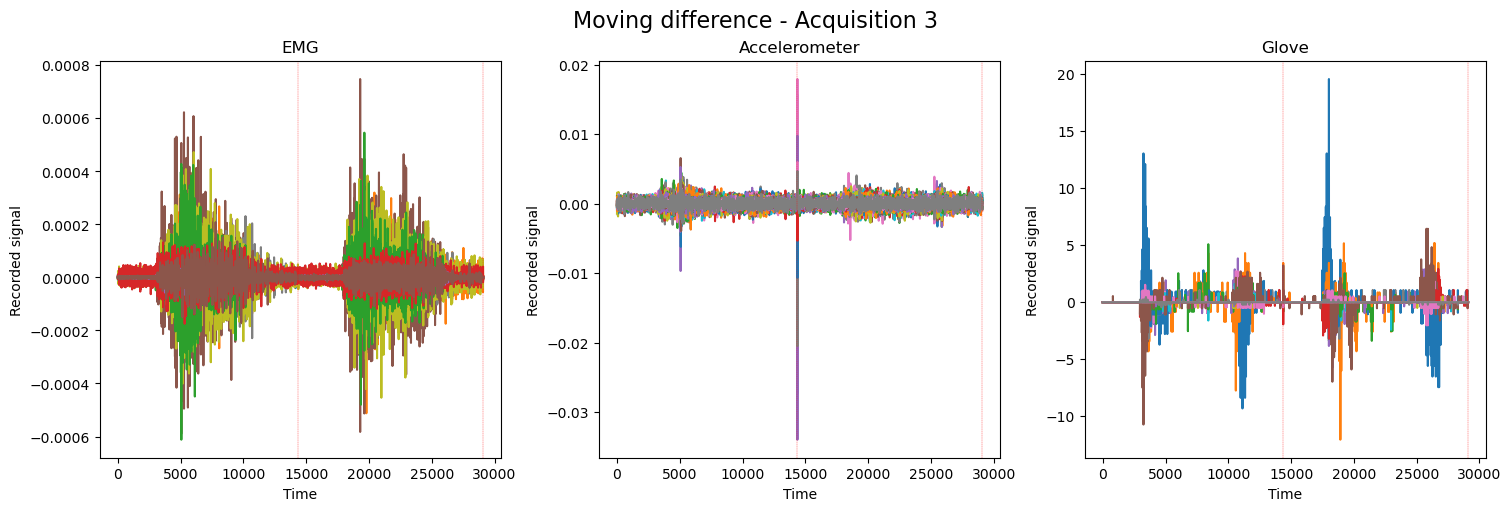

In [291]:
plot_data_difference(emg_dict1, emg_con1, acc_dict1, acc_con1, glove_dict1, glove_con1, 'Moving difference - Acquisition 1', 'Fig1_differences_acq_1')
plot_data_difference(emg_dict2, emg_con2, acc_dict2, acc_con2, glove_dict2, glove_con2, 'Moving difference - Acquisition 2', 'Fig1_differences_acq_2')
plot_data_difference(emg_dict3, emg_con3, acc_dict3, acc_con3, glove_dict3, glove_con3, 'Moving difference - Acquisition 3', 'Fig1_differences_acq_3')

It might not be viable to simply concatenate repetitions because the acceleration data show big spikes.

### Window Selection & Feature Extraction

In [292]:
time_window = 200 # 100 milliseconds
n_windows = 50 # windows per repetition

In [293]:
# Example of features
def features_estimation(signal, fs):
    """
    Compute time, frequency and time-frequency features from signal.
    :param signal: numpy array signal.
    :param channel_name: string variable with the EMG channel name in analysis.
    :param fs: int variable with the sampling frequency used to acquire the signal
    :return: total_feature_matrix -- python list
    :return: features_names -- python list with
    """

    features_names = ['VAR', 'RMS', 'IEMG', 'MAV', 'LOG', 'WL', 'ACC', 'DASDV', 'ZC', 'WAMP', 'MYOP', "MNP", "TP",
                      "MNF", "MDF", "PKF", "WENT"]

    time_matrix = time_features_estimation(signal)
    frequency_matrix = frequency_features_estimation(signal, fs)
    time_frequency_matrix = time_frequency_features_estimation(signal)
    total_feature_matrix = np.column_stack((time_matrix, frequency_matrix, time_frequency_matrix))

    return total_feature_matrix


def time_features_estimation(signal):
    """
    Compute time features from signal
    :param signal: numpy array signal.
    """

    th = np.mean(signal) + 3 * np.std(signal)

    variance = (np.var(signal))
    rms = (np.sqrt(np.mean(signal ** 2)))
    iemg = (np.sum(abs(signal)))  # Integral
    mav = (np.sum(np.absolute(signal)) / len(signal))  # Mean Absolute Value
    log_detector = (np.exp(np.sum(np.log10(np.absolute(signal))) / len(signal)))
    wl = (np.sum(abs(np.diff(signal))))  # Wavelength
    aac = (np.sum(abs(np.diff(signal))) / len(signal))  # Average Amplitude Change
    dasdv = (math.sqrt((1 / (len(signal) - 1)) * np.sum((np.diff(signal)) ** 2)))  # Difference absolute standard deviation value
    zc = (zcruce(signal, th))  # Zero-Crossing
    wamp = (wilson_amplitude(signal, th))  # Willison amplitude
    myop = (myopulse(signal, th))  # Myopulse percentage rate

    time_features_matrix = np.column_stack((variance, rms, iemg, mav, log_detector, wl, aac, dasdv, zc, wamp, myop))
    return time_features_matrix


def frequency_features_estimation(signal, fs):
    """
    Compute frequency features from signal
    :param signal: numpy array signal.
    :param fs: sampling frequency of the signal.
    :return: frequency_features_matrix: narray matrix with the frequency features stacked by columns.
    """

    frequency, power = spectrum(signal, fs)
    
    mnp = (np.sum(power) / len(power))  # Mean power
    tot = (np.sum(power))  # Total power
    mnf = (mean_freq(frequency, power))  # Mean frequency
    mdf = (median_freq(frequency, power))  # Median frequency
    pkf = (frequency[power.argmax()])  # Peak frequency

    frequency_features_matrix = np.column_stack((mnp, tot, mnf, mdf, pkf))

    return frequency_features_matrix


def time_frequency_features_estimation(signal):
    """
    Compute time-frequency features from signal
    :param signal: numpy array signal.
    :return: h_wavelet: list
    """
    h_wavelet = []

    E_a, E = wavelet_energy(signal, 'db2', 4)
    E.insert(0, E_a)
    E = np.asarray(E) / 100

    h_wavelet.append(-np.sum(E * np.log2(E)))

    return h_wavelet


def wilson_amplitude(signal, th):
    x = abs(np.diff(signal))
    umbral = x >= th
    return np.sum(umbral)


def myopulse(signal, th):
    umbral = signal >= th
    return np.sum(umbral) / len(signal)


def spectrum(signal, fs):
    m = len(signal)
    n = next_power_of_2(m)
    y = np.fft.fft(signal, n)
    yh = y[0:int(n / 2 - 1)]
    fh = (fs / n) * np.arange(0, n / 2 - 1, 1)
    power = np.real(yh * np.conj(yh) / n)

    return fh, power

def shannon(x):
    N = len(x)
    nb = 19
    hist, bin_edges = np.histogram(x, bins=nb)
    counts = hist / N
    nz = np.nonzero(counts)

    return np.sum(counts[nz] * np.log(counts[nz]) / np.log(2))


def zcruce(X, th):
    th = 0
    cruce = 0
    for cont in range(len(X) - 1):
        can = X[cont] * X[cont + 1]
        can2 = abs(X[cont] - X[cont + 1])
        if can < 0 and can2 > th:
            cruce = cruce + 1
    return cruce


def mean_freq(frequency, power):
    num = 0
    den = 0
    for i in range(int(len(power) / 2)):
        num += frequency[i] * power[i]
        den += power[i]

    return num / den


def median_freq(frequency, power):
    power_total = np.sum(power) / 2
    temp = 0
    tol = 0.01
    errel = 1
    i = 0

    while abs(errel) > tol:
        temp += power[i]
        errel = (power_total - temp) / power_total
        i += 1
        if errel < 0:
            errel = 0
            i -= 1

    return frequency[i]


def wavelet_energy(x, mother, nivel):
    coeffs = pywt.wavedecn(x, wavelet=mother, level=nivel)
    arr, _ = pywt.coeffs_to_array(coeffs)
    Et = np.sum(arr ** 2)
    cA = coeffs[0]
    Ea = 100 * np.sum(cA ** 2) / Et
    Ed = []

    for k in range(1, len(coeffs)):
        cD = list(coeffs[k].values())
        cD = np.asarray(cD)
        Ed.append(100 * np.sum(cD ** 2) / Et)

    return Ea, Ed


def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()


def med_freq(f, P):
    Ptot = np.sum(P) / 2
    temp = 0
    tol = 0.01
    errel = 1
    i = 0

    while abs(errel) > tol:
        temp += P[i]
        errel = (Ptot - temp) / Ptot
        i += 1
        if errel < 0:
            errel = 0
            i -= 1

    return f[i]

In [294]:
def get_features(data_dict, concat_data, n_features, n_time_steps, time_window):
    """Takes as input a dictionary of data and returns a dictionary of features.

    ## Parameters:
        - data_dict: dict
            
            Dictionary containing data per movement
        - concat_data: np.ndarray
        
            A n_repetitions * n_movements matrix containing the points at which repetitions were concatenated.
        - n_features: int

            The amount of features

        - n_time_steps: int

            The amount of window samples taken from each repetition
        
        - time_window: int

            Window length in time units (1/2000 sec)

    ## Returns:
        - features_dict: dict

            Dictionary containing features per movement per repetition

    """
    features_dict = {}
    for key in data_dict.keys():
        n_channels = data_dict[key].shape[1]
        movement = int(key)
        movement_features_dict = {}
        for repetition in range(concat_data.shape[0]):
            t_start = concat_data[repetition - 1, movement] if repetition != 0 else 0
            t_end = concat_data[repetition,movement]
            rep_features = np.zeros((n_time_steps, n_channels * n_features))
            time_steps = np.linspace(t_start, t_end - time_window, n_time_steps)
            for i in range(n_time_steps):
                t = int(time_steps[i])
                features_list = []
                for channel in range(n_channels):
                    windowed_signal = data_dict[key][t:time_window + t,channel]
                    channel_features = features_estimation(windowed_signal, 2000)
                    features_list.append(channel_features)
                rep_features[i,:] = np.hstack(features_list)
            # Normalization and cleanup
            mins = np.expand_dims(np.min(rep_features, axis=0), axis=0)
            maxs = np.expand_dims(np.max(rep_features, axis=0), axis=0)
            mins = np.tile(mins, [n_time_steps, 1])
            maxs = np.tile(maxs, [n_time_steps, 1])
            rep_features = (rep_features - mins) / (maxs - mins)
            rep_features[maxs - mins == 0] = 0.5
            if np.isnan(rep_features).any():
                print("!")
            movement_features_dict[str(repetition)] = rep_features
        features_dict[key] = movement_features_dict
    return features_dict

In [295]:
# Get features from emg data and acc data
emg_features_dict1 = get_features(emg_dict1, emg_con1, 17, n_windows, time_window)
acc_features_dict1 = get_features(acc_dict1, acc_con1, 17, n_windows, time_window)

emg_features_dict2 = get_features(emg_dict2, emg_con2, 17, n_windows, time_window)
acc_features_dict2 = get_features(acc_dict2, acc_con2, 17, n_windows, time_window)

emg_features_dict3 = get_features(emg_dict3, emg_con3, 17, n_windows, time_window)
acc_features_dict3 = get_features(acc_dict3, acc_con3, 17, n_windows, time_window)

In [296]:
def concatenate_emg_acc(emg_features_dict, acc_features_dict):    
    # Concatenate emg and acc features
    full_features_dict = {}
    for move_key in emg_features_dict.keys():
        movement_features_dict = {}
        for rep_key in emg_features_dict[move_key].keys():
            movement_features_dict[rep_key] = np.concatenate([emg_features_dict[move_key][rep_key], acc_features_dict[move_key][rep_key]], axis=1)
        full_features_dict[move_key] = movement_features_dict
        
    return full_features_dict

In [297]:
full_features_dict1 = concatenate_emg_acc(emg_features_dict1, acc_features_dict1)
full_features_dict2 = concatenate_emg_acc(emg_features_dict2, acc_features_dict2)
full_features_dict3 = concatenate_emg_acc(emg_features_dict3, acc_features_dict3)

In [298]:
def ft_heatmap(full_features_dict1, title, fname):
    fig, ax = plt.subplots()
    sns.heatmap(full_features_dict1['0']['0'][:,:], ax=ax)
    fig.suptitle(title, fontsize = 16)
    ax.set_xlabel('Features')
    ax.set_ylabel('Samples')
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()

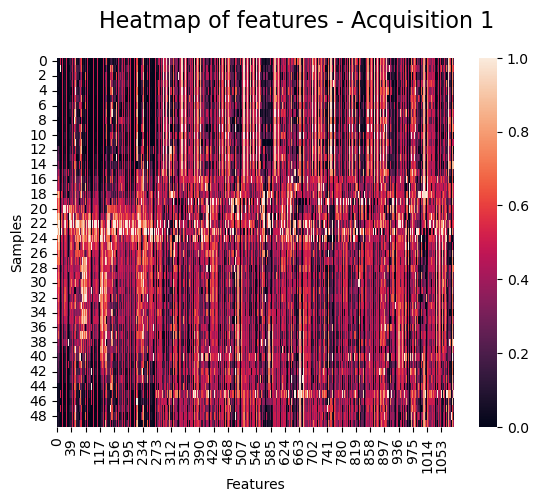

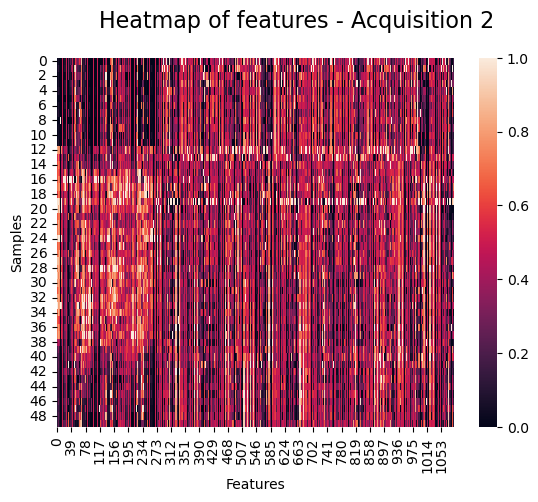

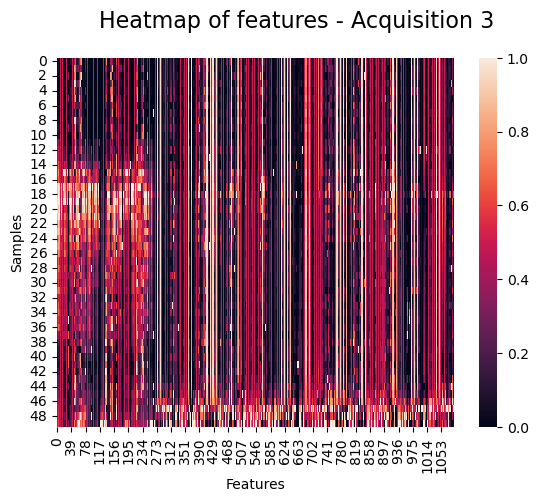

In [299]:
ft_heatmap(full_features_dict1, 'Heatmap of features - Acquisition 1', 'Fig2_ft_heatmap1')
ft_heatmap(full_features_dict2, 'Heatmap of features - Acquisition 2', 'Fig2_ft_heatmap2')
ft_heatmap(full_features_dict3, 'Heatmap of features - Acquisition 3', 'Fig2_ft_heatmap3')

In [300]:
def get_labels(data_dict, concat_data, n_time_steps, time_window):
    """Takes as input a dictionary and outputs labels per movement per repetition.

    ## Parameters:
        - data_dict: dict
            
            Dictionary containing data per movement
        - concat_data: np.ndarray
        
            A n_repetitions * n_movements matrix containing the points at which repetitions were concatenated.
        - n_features: int

            The amount of features

        - n_time_steps: int

            The amount of window samples taken from each repetition
        
        - time_window: int

            Window length in time units (1/2000 sec)

    ## Returns:
        - labels_dict:

            Dictionary containing labels per movement per repetition
    """
    labels_dict = {}
    for key in data_dict.keys():
        n_channels = data_dict[key].shape[1]
        movement = int(key)
        movement_labels_dict = {}
        for repetition in range(concat_data.shape[0]):
            t_start = concat_data[repetition - 1, movement] if repetition != 0 else 0
            t_end = concat_data[repetition,movement]
            rep_labels = np.zeros((n_time_steps, n_channels))
            time_steps = np.linspace(t_start + time_window, t_end - 1, n_time_steps)
            for i in range(n_time_steps):
                t = int(time_steps[i])
                rep_labels[i,:] = data_dict[key][t,:]
            movement_labels_dict[str(repetition)] = rep_labels
        labels_dict[key] = movement_labels_dict
    return labels_dict

In [301]:
# Get labels from glove data
labels_dict1 = get_labels(glove_dict1, glove_con1, n_windows, time_window)
labels_dict2 = get_labels(glove_dict2, glove_con2, n_windows, time_window)
labels_dict3 = get_labels(glove_dict3, glove_con3, n_windows, time_window)

In [302]:
def glove_heatmap(labels_dict, title, fname, test = False):    
    fig, ax = plt.subplots()
    if test:
        sns.heatmap(labels_dict['0']['1'][:,:], ax=ax)
    else:
        sns.heatmap(labels_dict['0']['9'][:,:], ax=ax)
    fig.suptitle(title, fontsize = 16)
    ax.set_xlabel('Glove channels')
    ax.set_ylabel('Samples')
    plt.savefig(fname)
    plt.show()

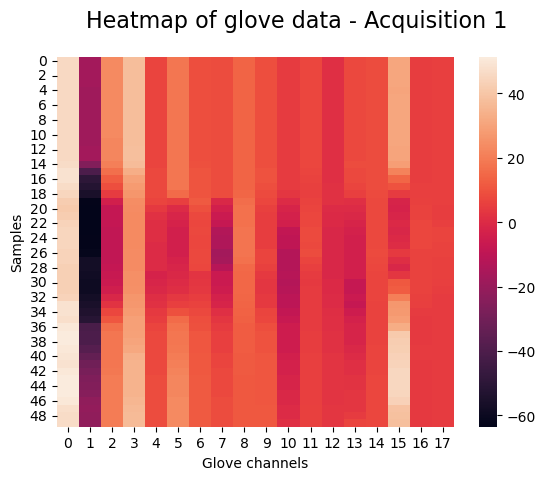

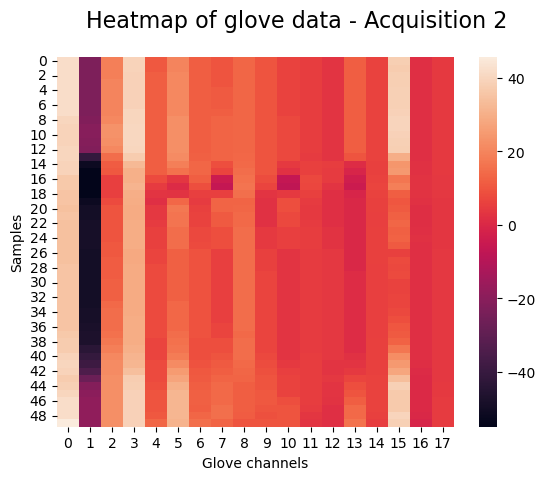

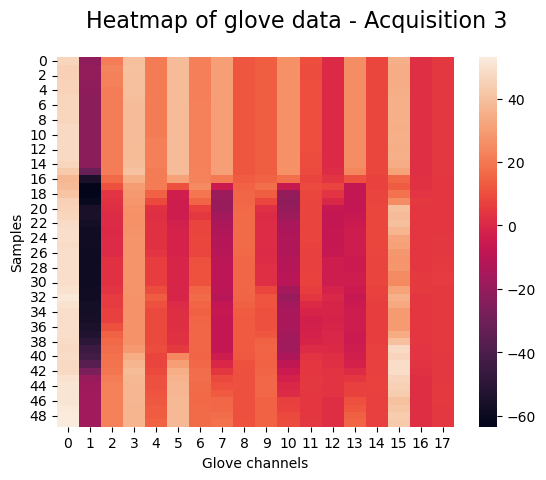

In [303]:
glove_heatmap(labels_dict1, 'Heatmap of glove data - Acquisition 1', 'Fig3_glove_heatmap1')
glove_heatmap(labels_dict2, 'Heatmap of glove data - Acquisition 2', 'Fig3_glove_heatmap2')
glove_heatmap(labels_dict3, 'Heatmap of glove data - Acquisition 3', 'Fig3_glove_heatmap3', True)

# Task 1

### Gather Training & Test Data

#### First Pass: Training on all movements, testing on a held-out repetition from each movement

In [304]:
def get_train_data(full_features_dict, labels_dict):
    
    X_train = None
    y_train = None
    for i in range(9):
        for j in range(10):
            if i == 0 and j == 0:
                X_train = full_features_dict[str(i)][str(j)]
                y_train = labels_dict[str(i)][str(j)]
            else:
                X_train = np.concatenate([X_train, full_features_dict[str(i)][str(j)]])
                y_train = np.concatenate([y_train, labels_dict[str(i)][str(j)]])
    
    return X_train, y_train
    
    
def get_test_data(full_features_dict, labels_dict):  
    
    X_test = None
    y_test = None

    for i in range(9):
        for j in range(2):
            if i == 0 and j == 0:
                X_test = full_features_dict[str(i)][str(j)]
                y_test = labels_dict[str(i)][str(j)]
            else:
                X_test = np.concatenate([X_test, full_features_dict[str(i)][str(j)]])
                y_test = np.concatenate([y_test, labels_dict[str(i)][str(j)]])
                
    return X_test, y_test

X_train1, y_train1 = get_train_data(full_features_dict1, labels_dict1)
X_train2, y_train2 = get_train_data(full_features_dict2, labels_dict2)
X_train = np.concatenate((X_train1, X_train2))
y_train = np.concatenate((y_train1, y_train2))

X_test, y_test = get_test_data(full_features_dict3, labels_dict3)

### Feature selection based on mutual information

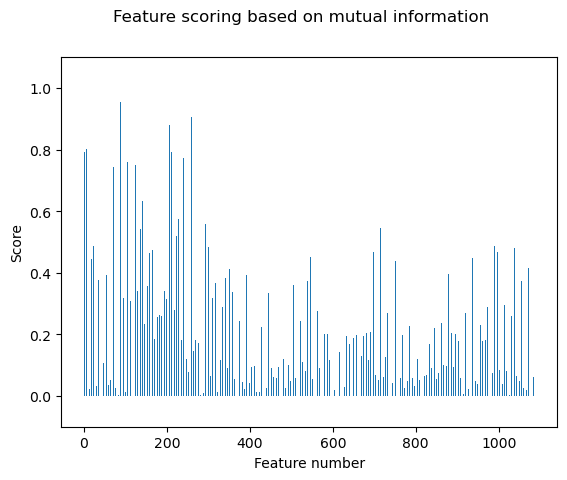

In [305]:
selector = SelectKBest(mutual_info_regression)
selector.fit(X_train, y_train[:,0])
scores = selector.scores_
scores /= scores.max()

fig, ax = plt.subplots()
fig.suptitle('Feature scoring based on mutual information')
ax.bar(np.arange(scores.shape[0]), scores, width=0.4)
ax.set_xlabel("Feature number")
ax.set_ylabel("Score")
ax.set_ylim([-0.1, 1.1])
plt.savefig('Fig4_task1_best_features')
plt.show()

### Train the Model

In [306]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

regressor=xgb.XGBRegressor()

selected_features = scores >= 0.2  # Select all features with a score >= 0.2

sel_X_train = X_train[:,selected_features]
sel_X_test = X_test[:,selected_features]

regressor=xgb.XGBRegressor()

eval_set = [(sel_X_train, y_train), (sel_X_test, y_test)]
eval_metric = ["rmse"]

regressor.fit(sel_X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, verbose=False)

predictions = regressor.predict(sel_X_test)

### Test the Accuracy & Visualize Predictions

In [307]:
from sklearn.metrics import mean_squared_error

n_channels = y_test.shape[1]
for channel in range(n_channels):
    RMSE = np.sqrt(mean_squared_error(y_test[:,channel], predictions[:,channel])) / (np.max(y_test[:,channel]) - np.min(y_test[:,channel]))
    print(f'The score for channel {channel + 1} is {RMSE:.5f}')

The score for channel 1 is 0.13084
The score for channel 2 is 0.16817
The score for channel 3 is 0.15736
The score for channel 4 is 0.17827
The score for channel 5 is 0.15056
The score for channel 6 is 0.20946
The score for channel 7 is 0.14312
The score for channel 8 is 0.19704
The score for channel 9 is 0.15672
The score for channel 10 is 0.15536
The score for channel 11 is 0.18654
The score for channel 12 is 0.11670
The score for channel 13 is 0.17906
The score for channel 14 is 0.19935
The score for channel 15 is 0.12983
The score for channel 16 is 0.18035
The score for channel 17 is 0.20012
The score for channel 18 is 0.20657


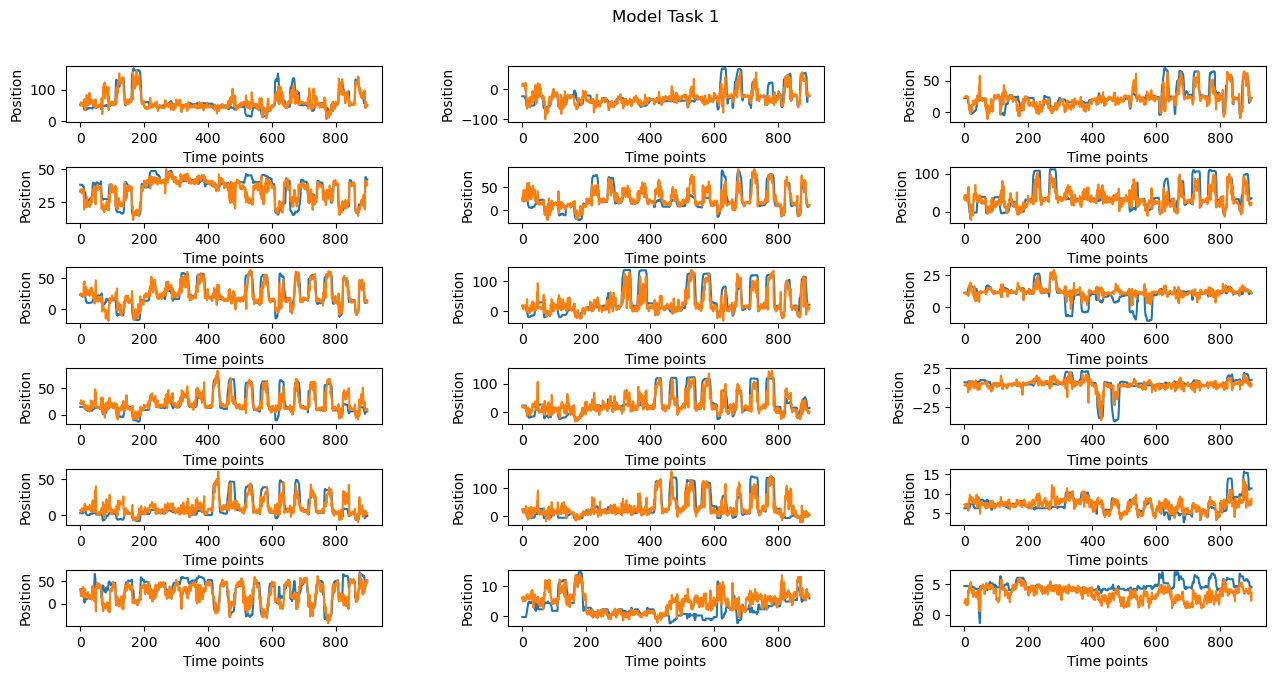

In [308]:
fig, ax = plt.subplots(6, 3, figsize=(15, 7))
ax = ax.ravel()

time_steps = y_test.shape[0]
n_channels = y_test.shape[1]

for i in range(n_channels):
    ax[i].plot(y_test[:,i], label='Ground Truth')
    ax[i].plot(predictions[:,i], label='Regression')

    ax[i].set_xlabel("Time points")
    ax[i].set_ylabel("Position")
    
fig.suptitle('Model Task 1')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.8)
plt.savefig('Fig5_task1_pred')
plt.show()

## Task 2: Disjoint movement classes - Train on 8 movements, test on the 9th

### Create data matrices

In [309]:
def get_train_data_disjoint(full_features_dict, labels_dict):
    
    X_train = None
    y_train = None
    for i in range(8):
        for j in range(10):
            if i == 0 and j == 0:
                X_train = full_features_dict[str(i)][str(j)]
                y_train = labels_dict[str(i)][str(j)]
            else:
                X_train = np.concatenate([X_train, full_features_dict[str(i)][str(j)]])
                y_train = np.concatenate([y_train, labels_dict[str(i)][str(j)]])
    
    return X_train, y_train
    
    
def get_test_data_disjoint(full_features_dict, labels_dict):  
    
    X_test = None
    y_test = None

    for i in range(8,9):
        for j in range(2):
            if i == 8 and j == 0:
                X_test = full_features_dict[str(i)][str(j)]
                y_test = labels_dict[str(i)][str(j)]
            else:
                X_test = np.concatenate([X_test, full_features_dict[str(i)][str(j)]])
                y_test = np.concatenate([y_test, labels_dict[str(i)][str(j)]])
                
    return X_test, y_test

X_train1, y_train1 = get_train_data_disjoint(full_features_dict1, labels_dict1)
X_train2, y_train2 = get_train_data_disjoint(full_features_dict2, labels_dict2)
X_train = np.concatenate((X_train1, X_train2))
y_train = np.concatenate((y_train1, y_train2))

X_test, y_test = get_test_data_disjoint(full_features_dict3, labels_dict3)

### Feature selection based on mutual information

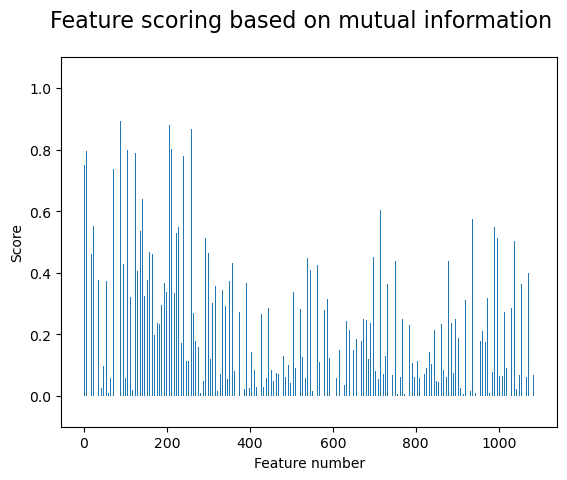

In [310]:
selector = SelectKBest(mutual_info_regression)
selector.fit(X_train, y_train[:,0])
scores = selector.scores_
scores /= scores.max()

fig, ax = plt.subplots()
fig.suptitle('Feature scoring based on mutual information', fontsize = 16)
ax.bar(np.arange(scores.shape[0]), scores, width=0.4)
ax.set_xlabel("Feature number")
ax.set_ylabel("Score")
ax.set_ylim([-0.1, 1.1])
plt.savefig('Fig6_task2_best_features')
plt.show()

### Model fitting and predicting

In [311]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

regressor=xgb.XGBRegressor()

selected_features = scores >= 0.2  # Select all features with a score >= 0.2

sel_X_train = X_train[:,selected_features]
sel_X_test = X_test[:,selected_features]

regressor=xgb.XGBRegressor()

eval_set = [(sel_X_train, y_train), (sel_X_test, y_test)]
eval_metric = ["rmse"]

regressor.fit(sel_X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, verbose=False)

predictions = regressor.predict(sel_X_test)

In [312]:
from sklearn.metrics import mean_squared_error

n_channels = y_test.shape[1]
for channel in range(n_channels):
    RMSE = np.sqrt(mean_squared_error(y_test[:,channel], predictions[:,channel])) / (np.max(y_test[:,channel]) - np.min(y_test[:,channel]))
    print(f'The score for channel {channel + 1} is {RMSE:.5f}')

The score for channel 1 is 0.29690
The score for channel 2 is 0.32151
The score for channel 3 is 0.25502
The score for channel 4 is 0.19784
The score for channel 5 is 0.18282
The score for channel 6 is 0.30839
The score for channel 7 is 0.18210
The score for channel 8 is 0.30403
The score for channel 9 is 0.38115
The score for channel 10 is 0.73257
The score for channel 11 is 0.36444
The score for channel 12 is 0.51869
The score for channel 13 is 0.84228
The score for channel 14 is 1.25087
The score for channel 15 is 0.46675
The score for channel 16 is 0.58107
The score for channel 17 is 0.23688
The score for channel 18 is 0.52674


### Plotting

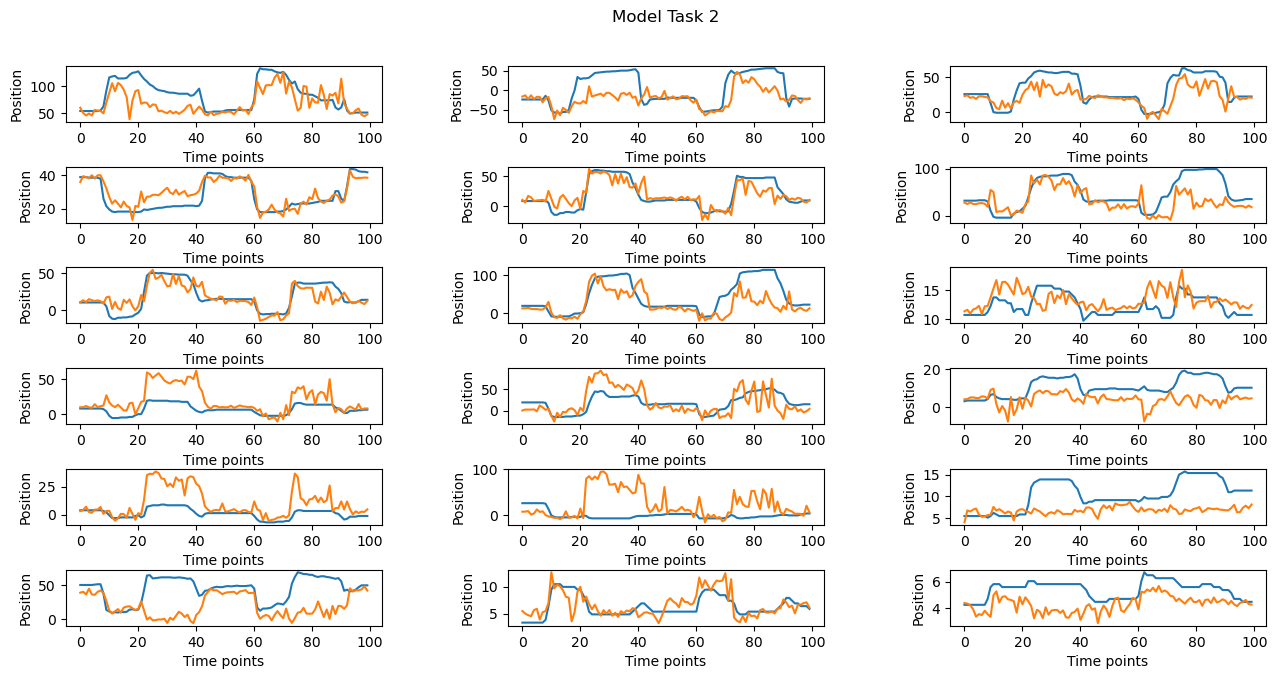

In [313]:
fig, ax = plt.subplots(6, 3, figsize=(15, 7))
ax = ax.ravel()

time_steps = y_test.shape[0]
n_channels = y_test.shape[1]

for i in range(n_channels):
    ax[i].plot(y_test[:,i], label='Ground Truth')
    ax[i].plot(predictions[:,i], label='Regression')
    
    ax[i].set_xlabel("Time points")
    ax[i].set_ylabel("Position")
    
fig.suptitle('Model Task 2')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.8)
plt.savefig('Fig7_task2_pred')
plt.show()

# Task 3: Add previous kinematic data as features

### Creating data matrices with 3 steps of kinematics history to the features

In [314]:
# n = 3: Be careful to make the right changes when tweaking this

def create_feat_dict_kinematics(emg_features_dict, acc_features_dict, glove_dict, glove_con, n_windows, time_window):
    full_features_dict = {}
    for move_key in emg_features_dict.keys():
        movement_features_dict = {}
        for rep_key in emg_features_dict[move_key].keys():
            movement_features_dict[rep_key] = np.concatenate([emg_features_dict[move_key][rep_key], acc_features_dict[move_key][rep_key]], axis=1)
        full_features_dict[move_key] = movement_features_dict

    labels_dict = get_labels(glove_dict, glove_con, n_windows, time_window)

    for move_key in full_features_dict.keys():
        for rep_key in full_features_dict[move_key].keys():
            rows = labels_dict[move_key][rep_key].shape[0]
            columns = labels_dict[move_key][rep_key].shape[1]
            added_features = np.zeros((rows, columns * 3))
            for time_step in range(3,rows):
                added_features[time_step,:columns] = labels_dict[move_key][rep_key][time_step - 1,:]
                added_features[time_step,columns:columns * 2] = labels_dict[move_key][rep_key][time_step - 2,:]
                added_features[time_step,columns * 2:columns * 3] = labels_dict[move_key][rep_key][time_step - 3,:]
            full_features_dict[move_key][rep_key] = full_features_dict[move_key][rep_key][3:,:]
            full_features_dict[move_key][rep_key] = np.concatenate([full_features_dict[move_key][rep_key], added_features[3:,:]], axis=1)
            labels_dict[move_key][rep_key] = labels_dict[move_key][rep_key][3:,:]
    return full_features_dict, labels_dict
        

In [315]:
kin_features_dict1, labels_dict1 = create_feat_dict_kinematics(emg_features_dict1, acc_features_dict1, glove_dict1, glove_con1, n_windows, time_window)
kin_features_dict2, labels_dict2 = create_feat_dict_kinematics(emg_features_dict2, acc_features_dict2, glove_dict2, glove_con2, n_windows, time_window)
kin_features_dict3, labels_dict3 = create_feat_dict_kinematics(emg_features_dict3, acc_features_dict3, glove_dict3, glove_con3, n_windows, time_window)

In [316]:
X_train1, y_train1 = get_train_data(kin_features_dict1, labels_dict1)
X_train2, y_train2 = get_train_data(kin_features_dict2, labels_dict2)
X_train = np.concatenate((X_train1, X_train2))
y_train = np.concatenate((y_train1, y_train2))

X_test, y_test = get_test_data(kin_features_dict3, labels_dict3)

### Feature selection

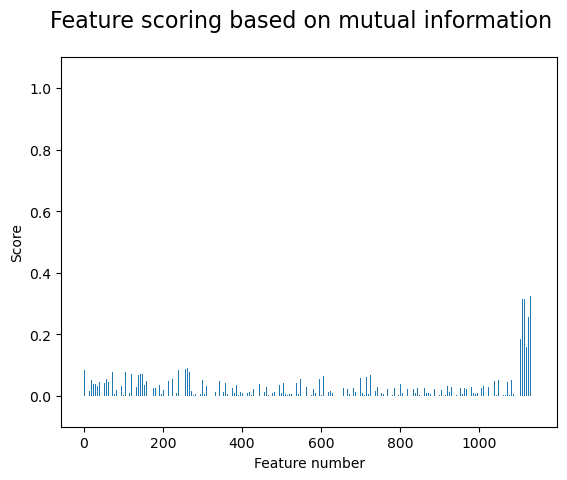

In [317]:
selector = SelectKBest(mutual_info_regression)
selector.fit(X_train, y_train[:,0])
scores = selector.scores_
scores /= scores.max()

fig, ax = plt.subplots()
fig.suptitle('Feature scoring based on mutual information', fontsize = 16)
ax.bar(np.arange(scores.shape[0]), scores, width=0.4)
ax.set_xlabel("Feature number")
ax.set_ylabel("Score")
ax.set_ylim([-0.1, 1.1])
plt.savefig('Fig8_task3_best_features')
plt.show()

### Model fitting and predicting

In [318]:
selected_features = scores > 0.02

sel_X_train = X_train[:,selected_features]
sel_X_test = X_test[:,selected_features]

regressor=xgb.XGBRegressor()

eval_set = [(sel_X_train, y_train), (sel_X_test, y_test)]
eval_metric = ["rmse"]

regressor.fit(sel_X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, verbose=False)

predictions = regressor.predict(sel_X_test)

In [319]:
from sklearn.metrics import mean_squared_error

n_channels = y_test.shape[1]
for channel in range(n_channels):
    RMSE = np.sqrt(mean_squared_error(y_test[:,channel], predictions[:,channel])) / (np.max(y_test[:,channel]) - np.min(y_test[:,channel]))
    print(f'The score for channel {channel + 1} is {RMSE:.5f}')

The score for channel 1 is 0.03338
The score for channel 2 is 0.04568
The score for channel 3 is 0.04886
The score for channel 4 is 0.04332
The score for channel 5 is 0.02843
The score for channel 6 is 0.04092
The score for channel 7 is 0.03216
The score for channel 8 is 0.03897
The score for channel 9 is 0.02950
The score for channel 10 is 0.03067
The score for channel 11 is 0.03203
The score for channel 12 is 0.01954
The score for channel 13 is 0.03223
The score for channel 14 is 0.03557
The score for channel 15 is 0.03071
The score for channel 16 is 0.04234
The score for channel 17 is 0.04049
The score for channel 18 is 0.03587


### Plotting

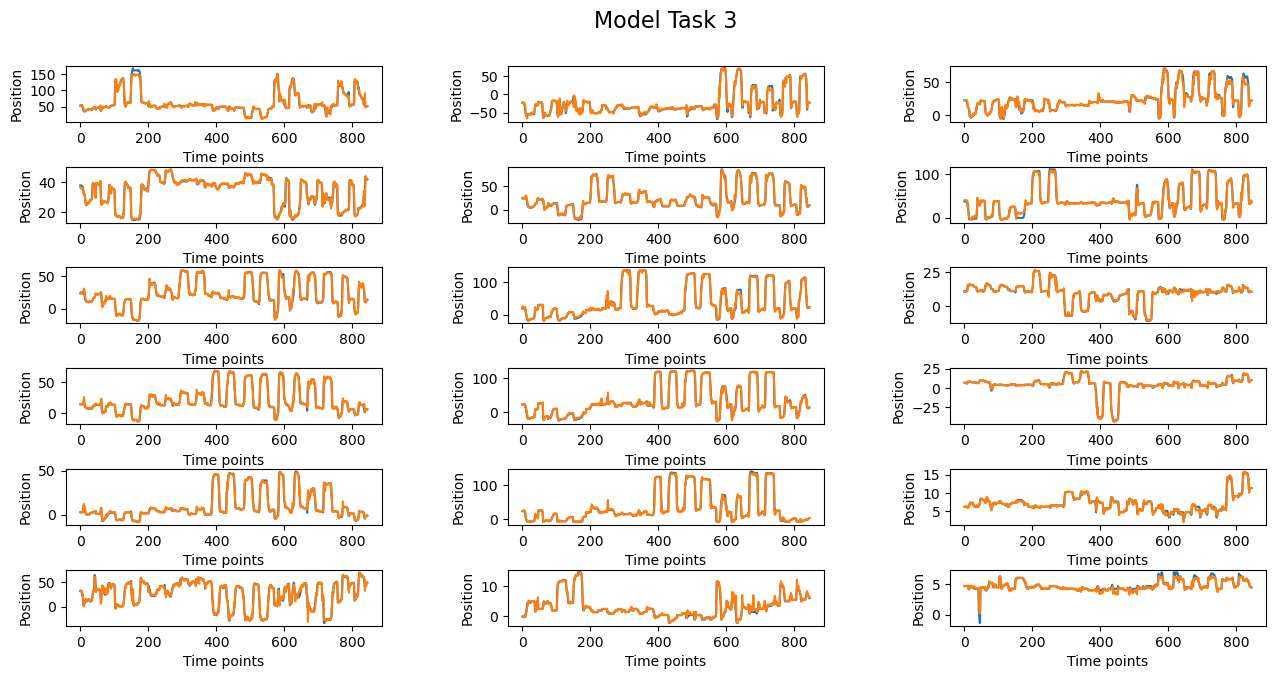

In [320]:
fig, ax = plt.subplots(6, 3, figsize=(15, 7))
ax = ax.ravel()

time_steps = y_test.shape[0]
n_channels = y_test.shape[1]

for i in range(n_channels):
    ax[i].plot(y_test[:,i], label='Ground Truth')
    ax[i].plot(predictions[:,i], label='Regression')
    ax[i].set_xlabel("Time points")
    ax[i].set_ylabel("Position")
    
fig.suptitle('Model Task 3', fontsize = 16)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.8)
plt.savefig('Fig9_task3_model')

plt.show()

# Realistic Model

In [321]:
rolling_predictions = np.empty(y_test.shape)
rolling_predictions[0,:] = y_test[0,:]
rolling_predictions[1,:] = y_test[1,:]
rolling_predictions[2,:] = y_test[2,:]

rolling_features = np.empty(sel_X_test.shape)

for i in range(3,y_test.shape[0]):
    rolling_features = np.hstack((sel_X_test[i][:-54], rolling_predictions[i-1], rolling_predictions[i-2], rolling_predictions[i-3]))
    rolling_features = np.reshape(rolling_features, (1,-1))
    rolling_predictions[i] = regressor.predict(rolling_features)

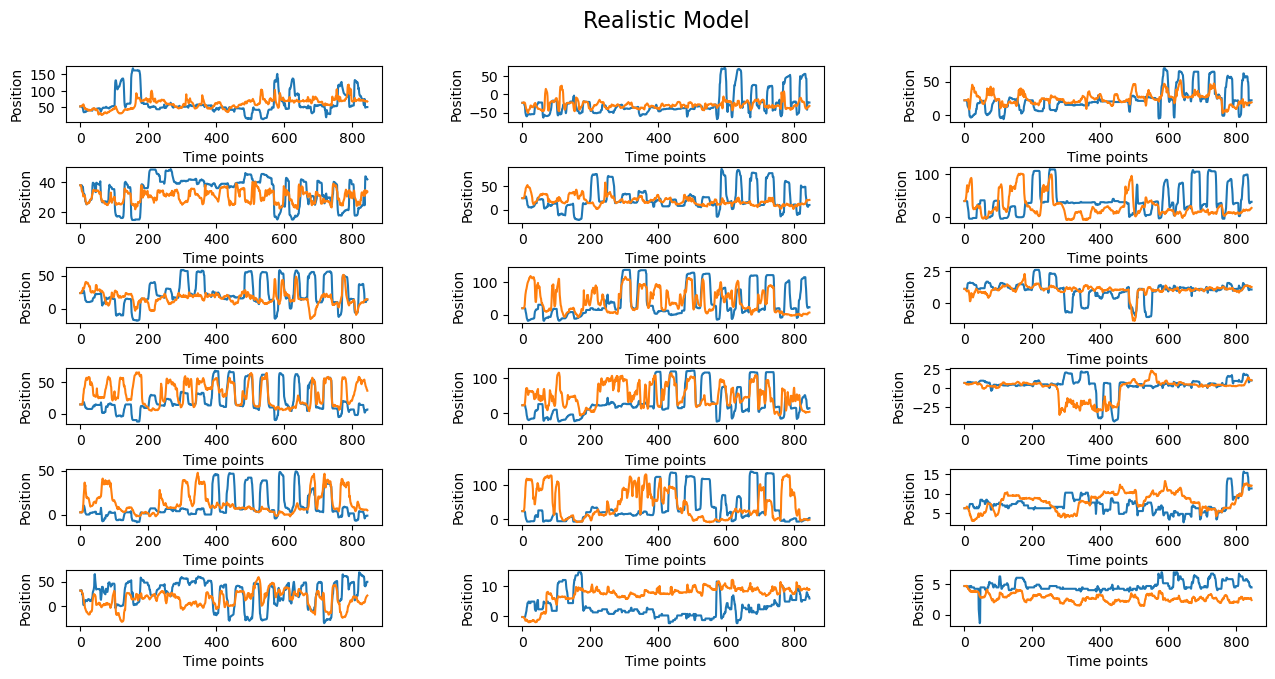

In [322]:
fig, ax = plt.subplots(6, 3, figsize=(15, 7))
ax = ax.ravel()

time_steps = y_test.shape[0]
n_channels = y_test.shape[1]

for i in range(n_channels):
    ax[i].plot(y_test[:,i], label='Ground Truth')
    ax[i].plot(rolling_predictions[:,i], label='Regression')
    ax[i].set_xlabel("Time points")
    ax[i].set_ylabel("Position")
    
fig.suptitle('Realistic Model', fontsize = 16)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.8)
plt.savefig('Fig10_realistic_model')
plt.show()